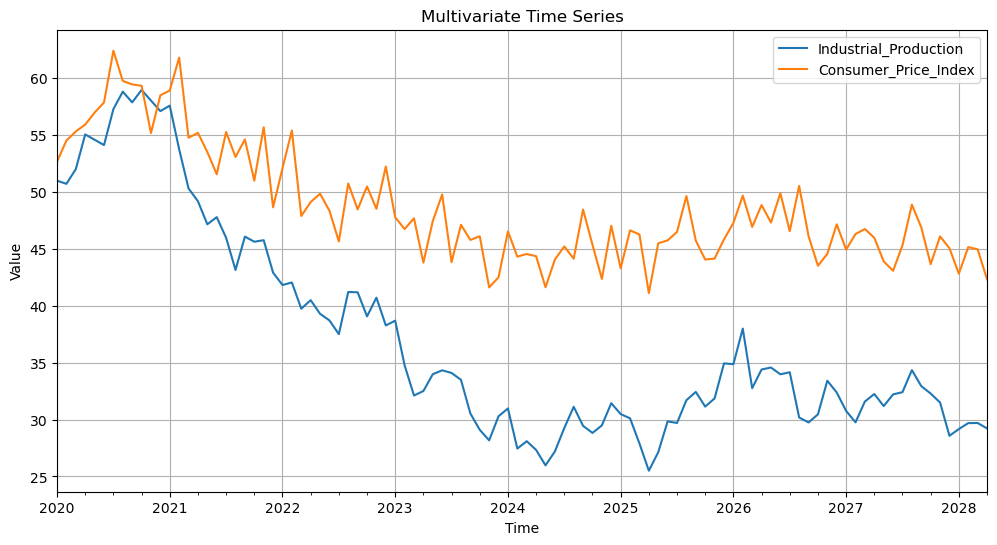

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Simulate two interdependent time series
np.random.seed(42)
time = pd.date_range(start="2020-01", periods=100, freq="ME")
industrial_production = 50 + np.cumsum(np.random.normal(0, 2, 100))
consumer_price_index = 30 + 0.5 * industrial_production + np.random.normal(0, 2, 100)
# Create a DataFrame
data = pd.DataFrame({
    "Industrial_Production": industrial_production,
    "Consumer_Price_Index": consumer_price_index,
}, index=time)
# Plot the data
data.plot(figsize=(12, 6), title="Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.savefig("Multivariate Time Series")
plt.show()

Industrial Production: p-value = 0.6021
Industrial Production is not stationary. Differencing required.
Consumer Price Index: p-value = 0.2883
Consumer Price Index is not stationary. Differencing required.


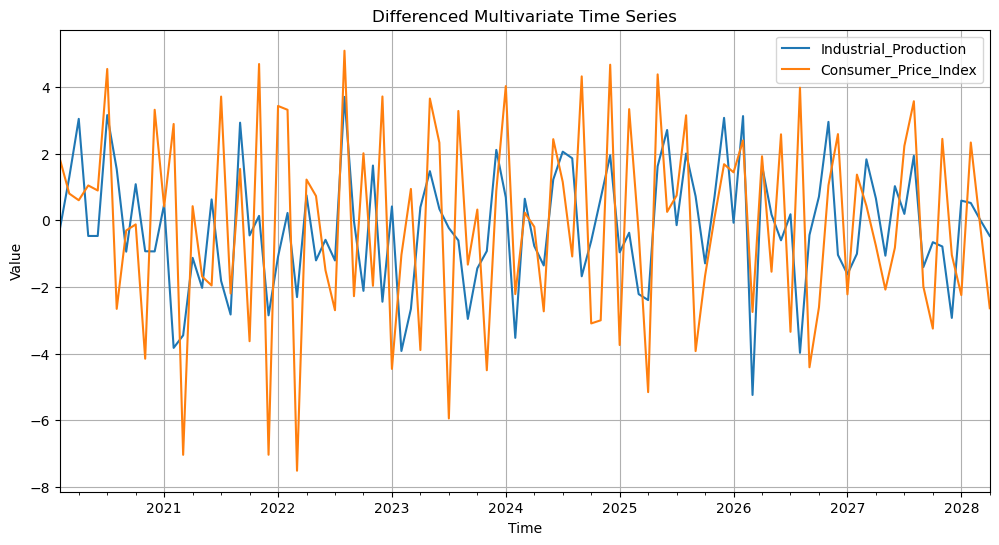

Lag Order Selection Criteria:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.282       3.340       26.63       3.305
1        3.007       3.181       20.23       3.077
2        2.799      3.089*       16.44      2.916*
3        2.873       3.278       17.71       3.036
4        2.863       3.384       17.55       3.073
5       2.724*       3.361      15.29*       2.980
6        2.761       3.513       15.89       3.063
7        2.819       3.687       16.89       3.168
8        2.850       3.834       17.48       3.245
9        2.883       3.983       18.15       3.325
10       2.930       4.145       19.13       3.418
11       2.899       4.230       18.69       3.434
12       2.896       4.342       18.78       3.477
13       2.934       4.497       19.72       3.562
14       2.823       4.502       17.86       3.498
15       2.794       4.588       17.59       3.515


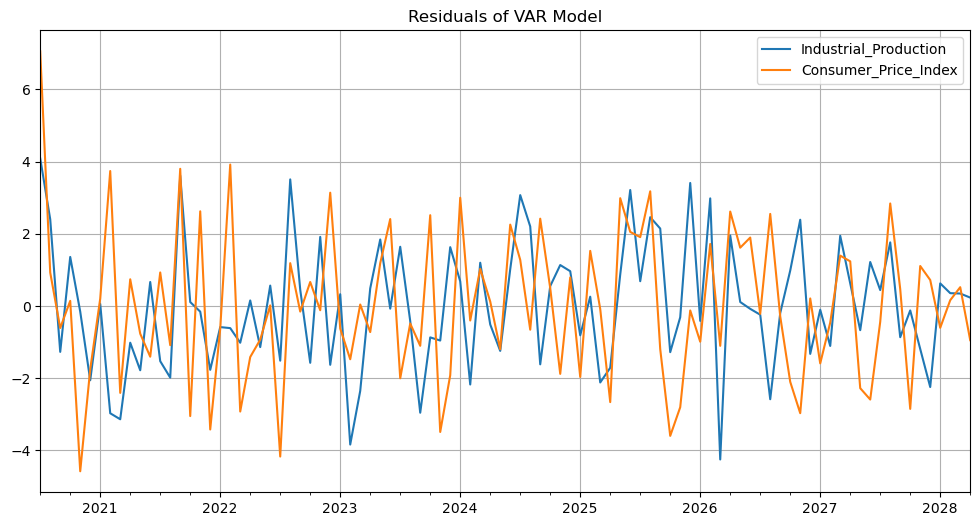

Durbin-Watson statistic for Industrial_Production: 1.93
Durbin-Watson statistic for Consumer_Price_Index: 2.08


/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_52700/3075021284.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=data.index[-1], periods=12, freq="M")


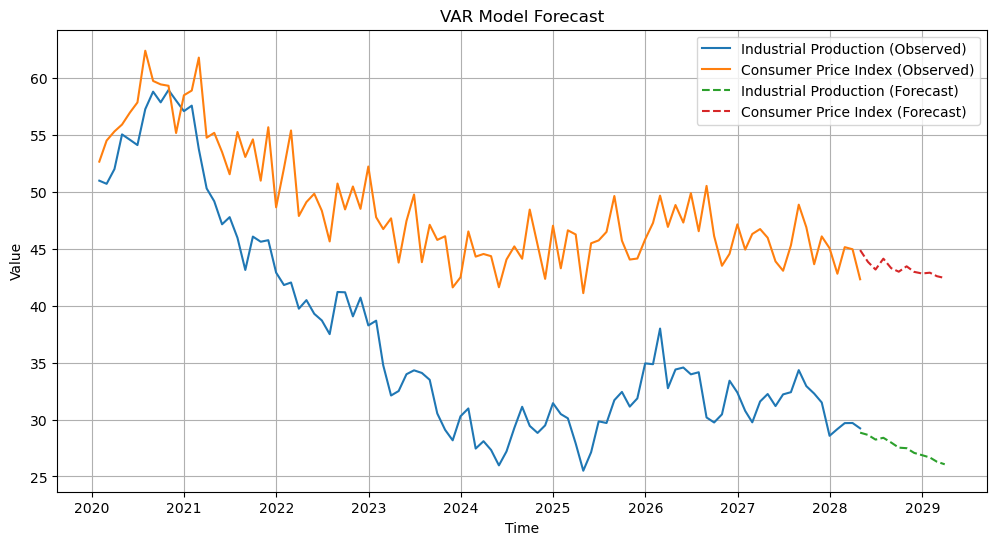

In [5]:
from statsmodels.tsa.stattools import adfuller
# Function to test stationarity
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"{name}: p-value = {result[1]:.4f}")
    if result[1] > 0.05:
        print(f"{name} is not stationary. Differencing required.")
    else:
        print(f"{name} is stationary.")
# Test stationarity for each series
check_stationarity(data["Industrial_Production"], "Industrial Production")
check_stationarity(data["Consumer_Price_Index"], "Consumer Price Index")

data_diff = data.diff().dropna()
# Plot differenced data
data_diff.plot(figsize=(12, 6), title="Differenced Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

from statsmodels.tsa.api import VAR
# Fit a VAR model
model = VAR(data_diff)
lag_order = model.select_order(maxlags=15)
print("Lag Order Selection Criteria:\n", lag_order.summary())
# Fit model with optimal lags
fitted_model = model.fit(lag_order.aic)
print(fitted_model.summary())

# Plot residuals
residuals = fitted_model.resid
residuals.plot(figsize=(12, 6), title="Residuals of VAR Model")
plt.grid()
plt.show()
# Check residual independence
from statsmodels.stats.stattools import durbin_watson
for i, col in enumerate(residuals.columns):
    dw_stat = durbin_watson(residuals[col])
    print(f"Durbin-Watson statistic for {col}: {dw_stat:.2f}")

# Forecast next 12 periods
forecast = fitted_model.forecast(data_diff.values[-lag_order.aic:], steps=12)
# Convert forecast to DataFrame
forecast_index = pd.date_range(start=data.index[-1], periods=12, freq="M")
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)
# Inverse differencing to get actual forecast
forecast_actual = forecast_df.cumsum() + data.iloc[-1]
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Industrial_Production"], label="Industrial Production (Observed)", linestyle="-")
plt.plot(data.index, data["Consumer_Price_Index"], label="Consumer Price Index (Observed)", linestyle="-")
plt.plot(forecast_actual.index, forecast_actual["Industrial_Production"], label="Industrial Production (Forecast)", linestyle="--")
plt.plot(forecast_actual.index, forecast_actual["Consumer_Price_Index"], label="Consumer Price Index (Forecast)", linestyle="--")
plt.title("VAR Model Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.savefig("VAR Model Forecast.png")
plt.show()


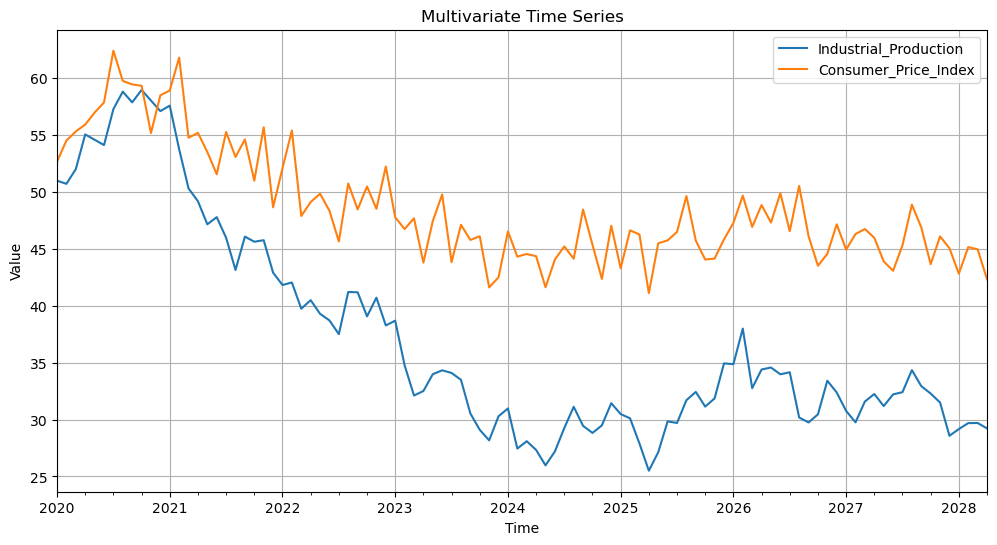

KeyError: 'date'

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Simulate two interdependent time series
np.random.seed(42)
time = pd.date_range(start="2020-01", periods=100, freq="ME")
industrial_production = 50 + np.cumsum(np.random.normal(0, 2, 100))
consumer_price_index = 30 + 0.5 * industrial_production + np.random.normal(0, 2, 100)
# Create a DataFrame
data = pd.DataFrame({
    "Industrial_Production": industrial_production,
    "Consumer_Price_Index": consumer_price_index,
}, index=time)
# Plot the data
data.plot(figsize=(12, 6), title="Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

# Ensure 'date' is a datetime object
data['date'] = pd.to_datetime(data['date'])

# Set 'date' as the index for plotting
data.set_index('date', inplace=True)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Prepare features and target
data['day_of_year'] = data.index.dayofyear  # Example feature
X = data[['day_of_year']]
y = data['value']

# Initialize storage for plotting
predictions = []
holdouts = []

# Perform cross-validation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train a model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Store the predictions and hold-out values
    predictions.append(pd.Series(y_pred, index=y_test.index))
    holdouts.append(y_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Fold {fold_idx + 1}: MSE = {mse:.4f}")

# Combine predictions and hold-outs into a single series
all_predictions = pd.concat(predictions).sort_index()
all_holdouts = pd.concat(holdouts).sort_index()

# Plot the actual values, hold-outs, and predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Actual Values (Full)', color='blue', linewidth=2)
plt.plot(all_holdouts.index, all_holdouts, label='Hold-Out Data', color='green', linewidth=2)
plt.plot(all_predictions.index, all_predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)
plt.title('Time Series Forecasting with TimeSeriesSplit')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('time_series_split_forecast.png')
plt.show()


Fold 1: MSE = 2.3128
Fold 2: MSE = 1.1260
Fold 3: MSE = 1.4607
Fold 4: MSE = 3.2642
Fold 5: MSE = 0.1934


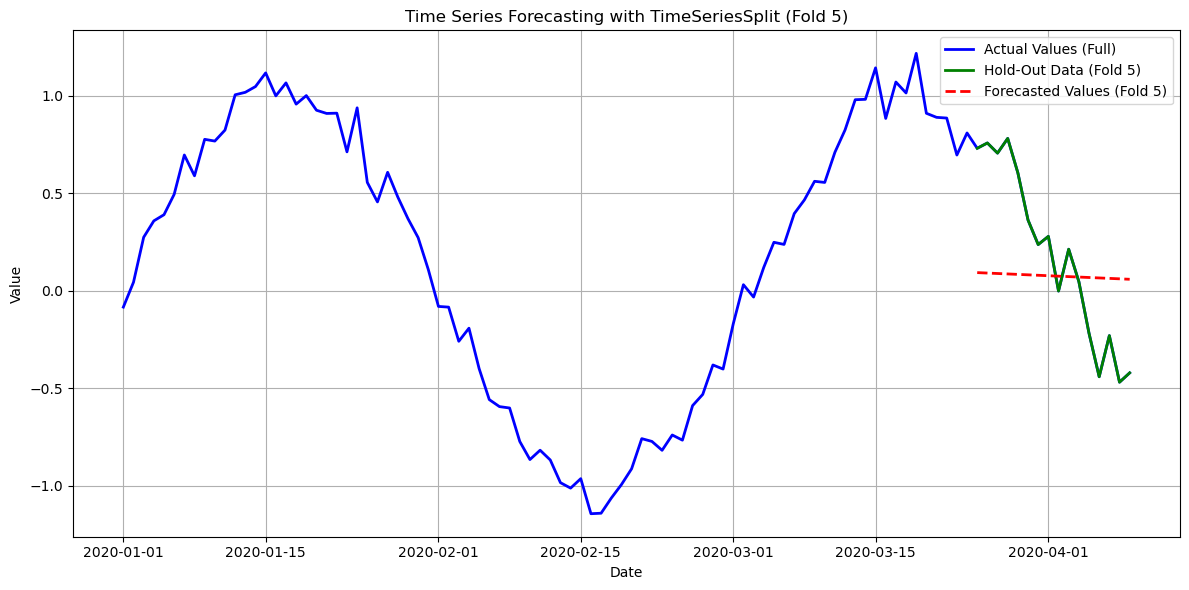

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a sample time series dataframe
data = pd.DataFrame({'date': pd.date_range(start='1/1/2020', periods=100, freq='D'),
                     'value': np.sin(np.linspace(0, 10, 100)) + np.random.normal(0, 0.1, 100)})

# Ensure 'date' is a datetime object
data['date'] = pd.to_datetime(data['date'])

# Set 'date' as the index for plotting
data.set_index('date', inplace=True)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Prepare features and target
data['day_of_year'] = data.index.dayofyear  # Example feature
X = data[['day_of_year']]
y = data['value']

# Initialize storage for fold 5
fold_5_predictions = None
fold_5_holdouts = None

# Perform cross-validation
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train a model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Store predictions and hold-outs for fold 5
    if fold_idx == 5:
        fold_5_predictions = pd.Series(y_pred, index=y_test.index)
        fold_5_holdouts = y_test

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Fold {fold_idx}: MSE = {mse:.4f}")

# Plot the actual values, hold-outs, and predictions for fold 5
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Actual Values (Full)', color='blue', linewidth=2)
if fold_5_holdouts is not None:
    plt.plot(fold_5_holdouts.index, fold_5_holdouts, label='Hold-Out Data (Fold 5)', color='green', linewidth=2)
if fold_5_predictions is not None:
    plt.plot(fold_5_predictions.index, fold_5_predictions, label='Forecasted Values (Fold 5)', color='red', linestyle='--', linewidth=2)
plt.title('Time Series Forecasting with TimeSeriesSplit (Fold 5)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('time_series_split_fold_5_forecast.png')
plt.show()


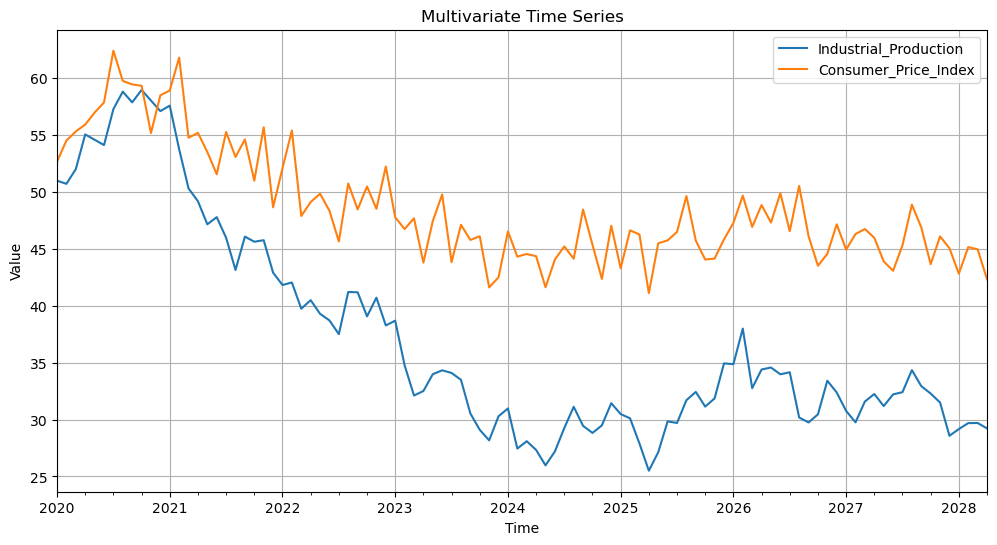

Industrial Production: p-value = 0.6021
Industrial Production is not stationary. Differencing required.
Consumer Price Index: p-value = 0.2883
Consumer Price Index is not stationary. Differencing required.
Lag Order Selection Criteria:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.540       3.607       34.46       3.566
1        3.216       3.418       24.93       3.296
2       2.990*      3.327*      19.90*      3.123*
3        3.108       3.580       22.41       3.294
4        3.141       3.748       23.20       3.380
5        3.049       3.792       21.25       3.342
6        3.120       3.997       22.91       3.465
7        3.213       4.225       25.29       3.611
8        3.227       4.374       25.87       3.679
9        3.257       4.539       26.95       3.762
10       3.346       4.763       29.86       3.904
11       3.349       4.900       30.44       3.96

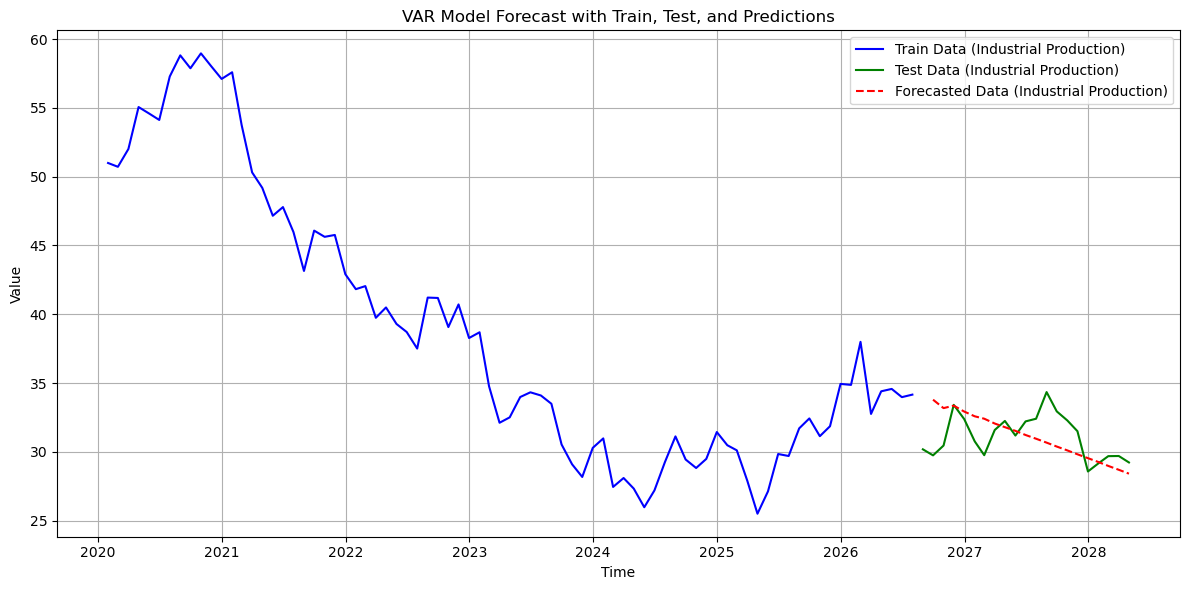

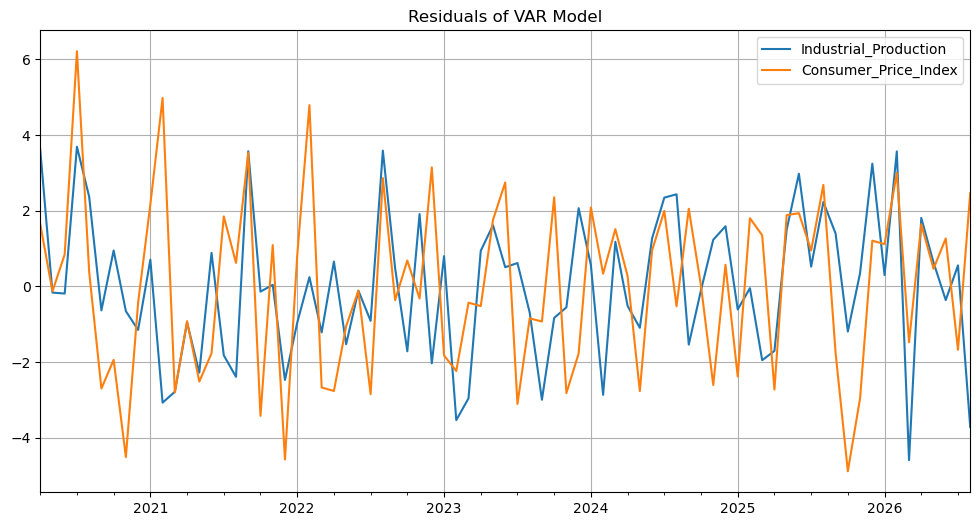

Durbin-Watson statistic for Industrial_Production: 1.94
Durbin-Watson statistic for Consumer_Price_Index: 2.05


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Simulate two interdependent time series
np.random.seed(42)
time = pd.date_range(start="2020-01", periods=100, freq="ME")
industrial_production = 50 + np.cumsum(np.random.normal(0, 2, 100))
consumer_price_index = 30 + 0.5 * industrial_production + np.random.normal(0, 2, 100)
# Create a DataFrame
data = pd.DataFrame({
    "Industrial_Production": industrial_production,
    "Consumer_Price_Index": consumer_price_index,
}, index=time)
# Plot the data
data.plot(figsize=(12, 6), title="Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

# Check stationarity
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"{name}: p-value = {result[1]:.4f}")
    if result[1] > 0.05:
        print(f"{name} is not stationary. Differencing required.")
    else:
        print(f"{name} is stationary.")

check_stationarity(data["Industrial_Production"], "Industrial Production")
check_stationarity(data["Consumer_Price_Index"], "Consumer Price Index")

# Differencing for stationarity
data_diff = data.diff().dropna()

# Train-test split
train_size = int(len(data_diff) * 0.8)  # 80% train, 20% test
train_data = data_diff.iloc[:train_size]
test_data = data_diff.iloc[train_size:]

# Fit a VAR model
model = VAR(train_data)
lag_order = model.select_order(maxlags=15)
print("Lag Order Selection Criteria:\n", lag_order.summary())
optimal_lag = lag_order.aic
fitted_model = model.fit(optimal_lag)
print(fitted_model.summary())

# Forecast next len(test_data) periods
forecast = fitted_model.forecast(train_data.values[-optimal_lag:], steps=len(test_data))

# Convert forecast to DataFrame
forecast_index = test_data.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_diff.columns)

# Inverse differencing to return to original scale
forecast_actual = forecast_df.cumsum() + data.iloc[train_size - 1]

# Plot train, test, and forecast
plt.figure(figsize=(12, 6))

# Plot train data
plt.plot(data.iloc[:train_size].index, data.iloc[:train_size]["Industrial_Production"], label="Train Data (Industrial Production)", color="blue")

# Plot test data
plt.plot(data.iloc[train_size:].index, data.iloc[train_size:]["Industrial_Production"], label="Test Data (Industrial Production)", color="green")

# Plot forecasted data
plt.plot(forecast_actual.index, forecast_actual["Industrial_Production"], label="Forecasted Data (Industrial Production)", linestyle="--", color="red")

# Add labels for clarity
plt.title("VAR Model Forecast with Train, Test, and Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("train_test_forecast_plot.png")
plt.show()

# Residual analysis
residuals = fitted_model.resid
residuals.plot(figsize=(12, 6), title="Residuals of VAR Model")
plt.grid()
plt.show()

# Durbin-Watson test for residual independence
for i, col in enumerate(residuals.columns):
    dw_stat = durbin_watson(residuals[col])
    print(f"Durbin-Watson statistic for {col}: {dw_stat:.2f}")


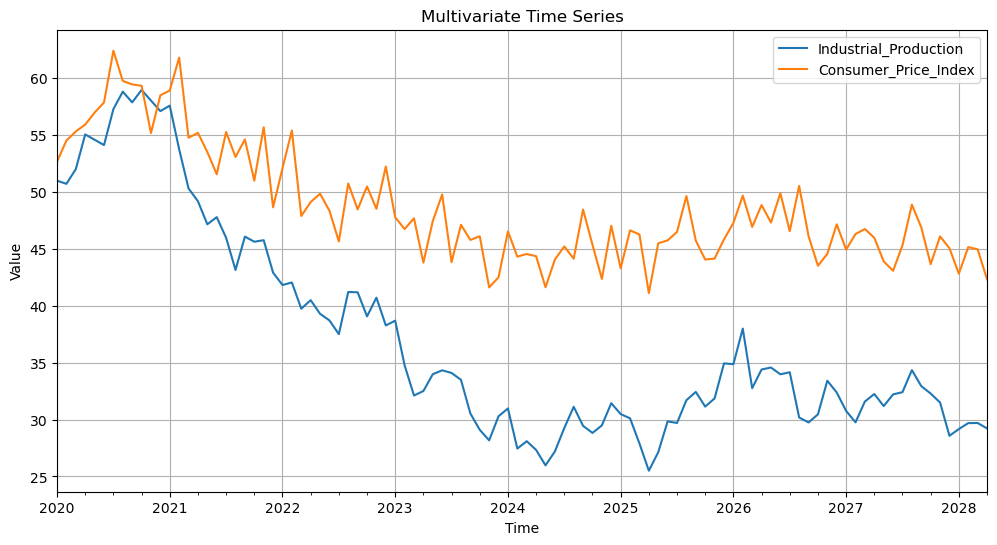

Industrial Production: p-value = 0.6021
Industrial Production is not stationary. Differencing required.
Consumer Price Index: p-value = 0.2883
Consumer Price Index is not stationary. Differencing required.
VAR Lag Order Selection Criteria:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.540       3.607       34.46       3.566
1        3.216       3.418       24.93       3.296
2       2.990*      3.327*      19.90*      3.123*
3        3.108       3.580       22.41       3.294
4        3.141       3.748       23.20       3.380
5        3.049       3.792       21.25       3.342
6        3.120       3.997       22.91       3.465
7        3.213       4.225       25.29       3.611
8        3.227       4.374       25.87       3.679
9        3.257       4.539       26.95       3.762
10       3.346       4.763       29.86       3.904
11       3.349       4.900       30.44       

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


VARMA Model Summary:
                                            Statespace Model Results                                          
Dep. Variable:     ['Industrial_Production', 'Consumer_Price_Index']   No. Observations:                   79
Model:                                                    VARMA(2,1)   Log Likelihood                -327.457
                                                         + intercept   AIC                            688.914
Date:                                               Tue, 14 Jan 2025   BIC                            729.194
Time:                                                       15:51:18   HQIC                           705.051
Sample:                                                   02-29-2020                                         
                                                        - 08-31-2026                                         
Covariance Type:                                                 opg                              

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


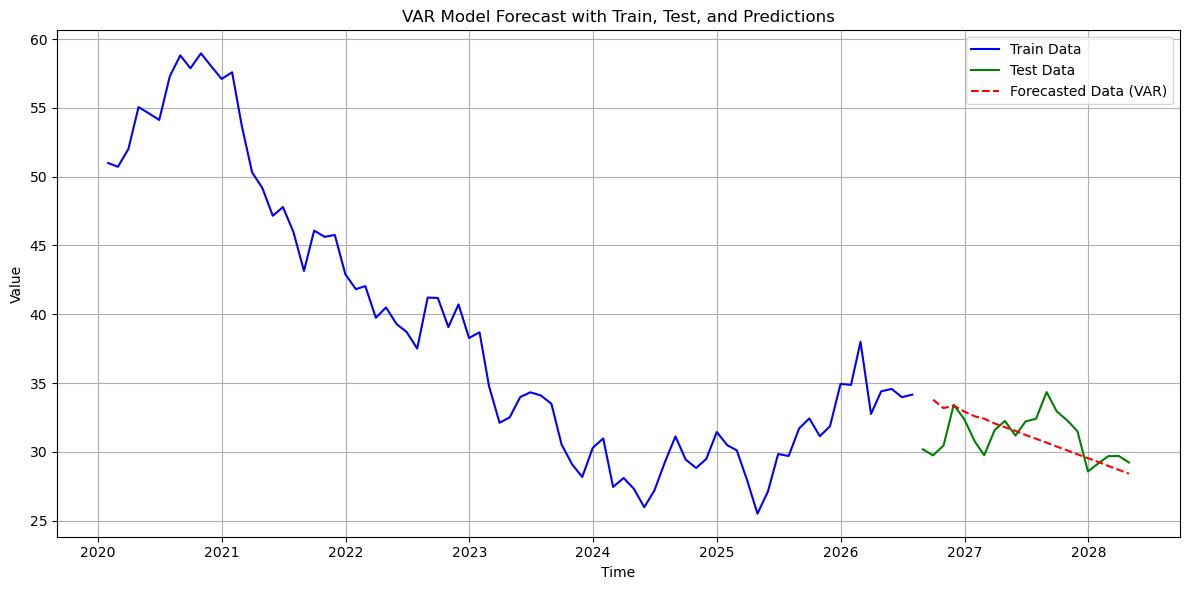

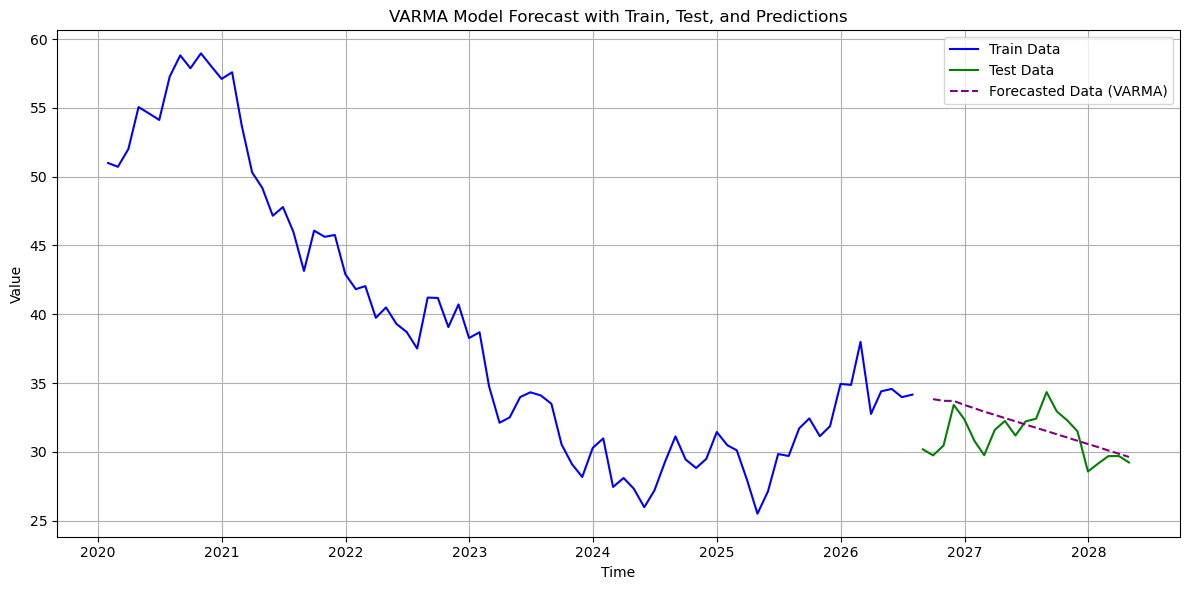

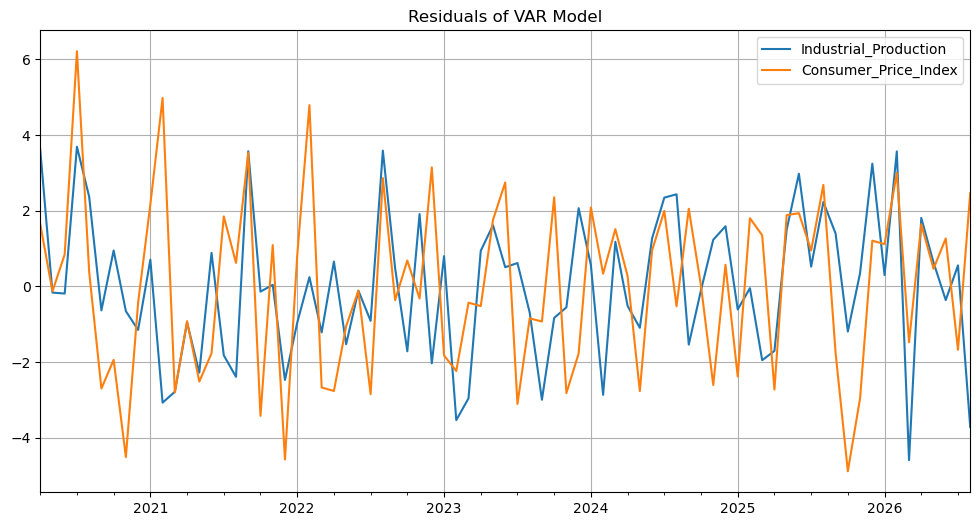

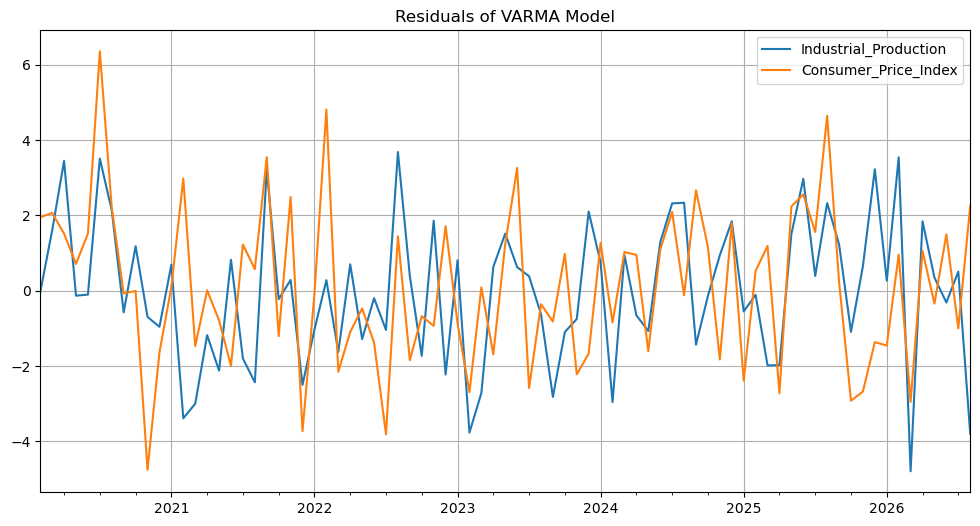

Durbin-Watson Statistics:
VAR - Industrial_Production: 1.94
VAR - Consumer_Price_Index: 2.05
VARMA - Industrial_Production: 1.94
VARMA - Consumer_Price_Index: 1.94


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

# Simulate two interdependent time series
np.random.seed(42)
time = pd.date_range(start="2020-01", periods=100, freq="ME")
industrial_production = 50 + np.cumsum(np.random.normal(0, 2, 100))
consumer_price_index = 30 + 0.5 * industrial_production + np.random.normal(0, 2, 100)

# Create a DataFrame
data = pd.DataFrame({
    "Industrial_Production": industrial_production,
    "Consumer_Price_Index": consumer_price_index,
}, index=time)

# Plot the data
data.plot(figsize=(12, 6), title="Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

# Check stationarity
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"{name}: p-value = {result[1]:.4f}")
    if result[1] > 0.05:
        print(f"{name} is not stationary. Differencing required.")
    else:
        print(f"{name} is stationary.")

check_stationarity(data["Industrial_Production"], "Industrial Production")
check_stationarity(data["Consumer_Price_Index"], "Consumer Price Index")

# Differencing for stationarity
data_diff = data.diff().dropna()

# Train-test split
train_size = int(len(data_diff) * 0.8)  # 80% train, 20% test
train_data = data_diff.iloc[:train_size]
test_data = data_diff.iloc[train_size:]

# Fit a VAR model
var_model = VAR(train_data)
var_lag_order = var_model.select_order(maxlags=15)
print("VAR Lag Order Selection Criteria:\n", var_lag_order.summary())
var_optimal_lag = var_lag_order.aic
var_fitted_model = var_model.fit(var_optimal_lag)
print(var_fitted_model.summary())

# Fit a VARMA model
varma_model = VARMAX(train_data, order=(var_optimal_lag, 1))
varma_fitted_model = varma_model.fit(disp=False)
print("VARMA Model Summary:\n", varma_fitted_model.summary())

# Forecast next len(test_data) periods for VAR
var_forecast = var_fitted_model.forecast(train_data.values[-var_optimal_lag:], steps=len(test_data))

# Forecast next len(test_data) periods for VARMA
varma_forecast = varma_fitted_model.forecast(steps=len(test_data))

# Convert forecasts to DataFrames
forecast_index = test_data.index
var_forecast_df = pd.DataFrame(var_forecast, index=forecast_index, columns=data_diff.columns)
varma_forecast_df = pd.DataFrame(varma_forecast, index=forecast_index, columns=data_diff.columns)

# Inverse differencing to return to original scale
var_forecast_actual = var_forecast_df.cumsum() + data.iloc[train_size - 1]
varma_forecast_actual = varma_forecast_df.cumsum() + data.iloc[train_size - 1]

# Plot train, test, and forecast (VAR)
plt.figure(figsize=(12, 6))
plt.plot(data.iloc[:train_size].index, data.iloc[:train_size]["Industrial_Production"], label="Train Data", color="blue")
plt.plot(data.iloc[train_size:].index, data.iloc[train_size:]["Industrial_Production"], label="Test Data", color="green")
plt.plot(var_forecast_actual.index, var_forecast_actual["Industrial_Production"], label="Forecasted Data (VAR)", linestyle="--", color="red")
plt.title("VAR Model Forecast with Train, Test, and Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot train, test, and forecast (VARMA)
plt.figure(figsize=(12, 6))
plt.plot(data.iloc[:train_size].index, data.iloc[:train_size]["Industrial_Production"], label="Train Data", color="blue")
plt.plot(data.iloc[train_size:].index, data.iloc[train_size:]["Industrial_Production"], label="Test Data", color="green")
plt.plot(varma_forecast_actual.index, varma_forecast_actual["Industrial_Production"], label="Forecasted Data (VARMA)", linestyle="--", color="purple")
plt.title("VARMA Model Forecast with Train, Test, and Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Residual analysis for VAR
var_residuals = var_fitted_model.resid
var_residuals.plot(figsize=(12, 6), title="Residuals of VAR Model")
plt.grid()
plt.show()

# Residual analysis for VARMA
varma_residuals = varma_fitted_model.resid
varma_residuals.plot(figsize=(12, 6), title="Residuals of VARMA Model")
plt.grid()
plt.show()

# Durbin-Watson test for residual independence
print("Durbin-Watson Statistics:")
for i, col in enumerate(var_residuals.columns):
    dw_stat_var = durbin_watson(var_residuals[col])
    print(f"VAR - {col}: {dw_stat_var:.2f}")

for i, col in enumerate(varma_residuals.columns):
    dw_stat_varma = durbin_watson(varma_residuals[col])
    print(f"VARMA - {col}: {dw_stat_varma:.2f}")


In [21]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# Differencing for stationarity
data_diff_scaled = data_scaled.diff().dropna()

# Fit a VARMA model with reduced complexity
varma_model = VARMAX(data_diff_scaled, order=(2, 1))  # Lower lag and MA orders
varma_fitted_model = varma_model.fit(maxiter=1000, disp=False)  # Increase iterations

# Check model fit summary
print(varma_fitted_model.summary())


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                                           Statespace Model Results                                          
Dep. Variable:     ['Industrial_Production', 'Consumer_Price_Index']   No. Observations:                   99
Model:                                                    VARMA(2,1)   Log Likelihood                 -23.433
                                                         + intercept   AIC                             80.867
Date:                                               Tue, 14 Jan 2025   BIC                            124.984
Time:                                                       15:52:30   HQIC                            98.716
Sample:                                                   02-29-2020                                         
                                                        - 04-30-2028                                         
Covariance Type:                                                 opg                                         
Ljung-Box 

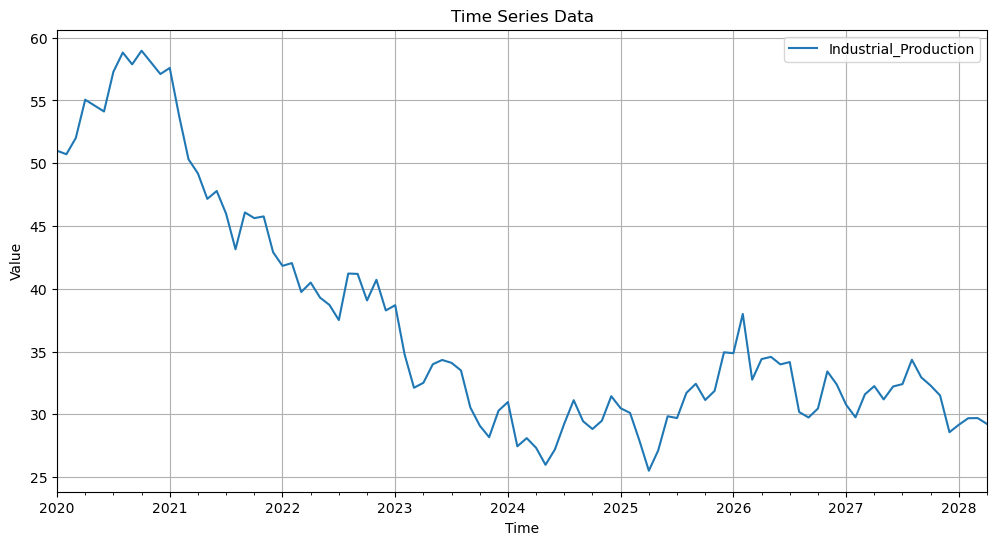

ADF Statistic: -1.3583
p-value: 0.6021
The series is non-stationary. Differencing required.


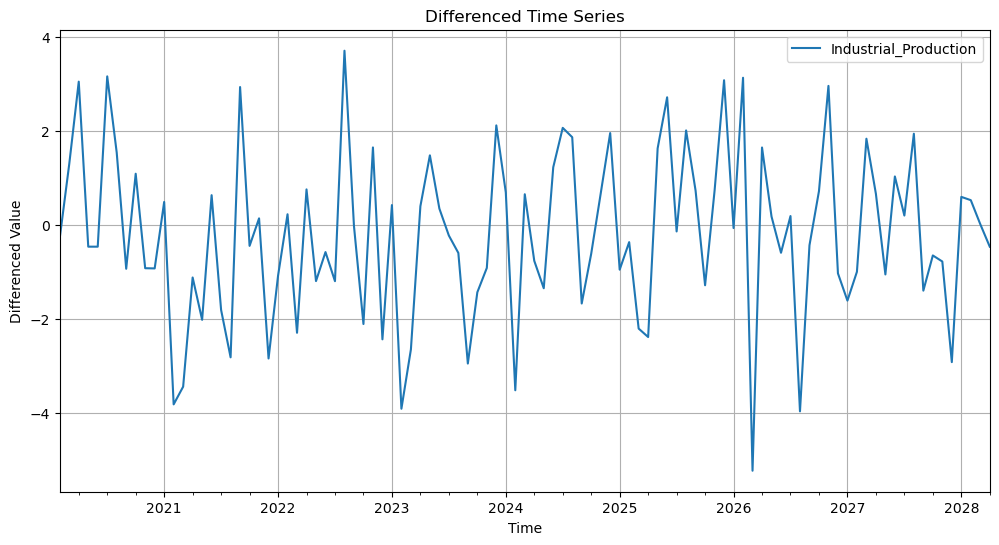

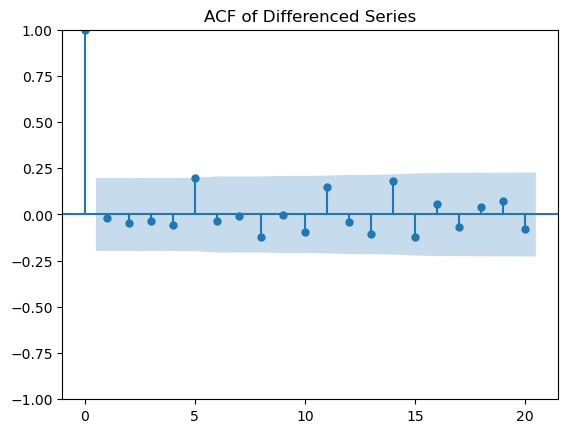

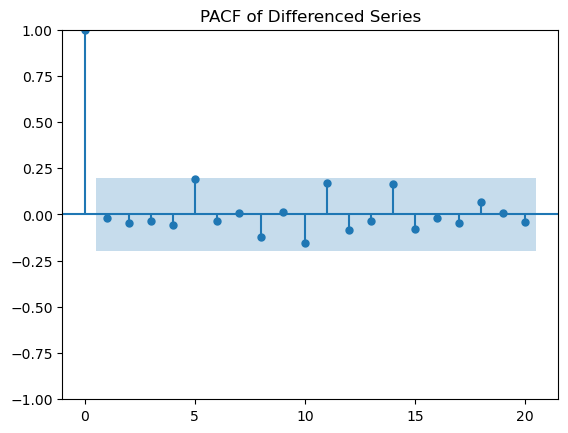

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=402.678, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=404.633, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=404.628, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=402.124, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=406.470, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.217 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -200.062
Date:                Tue, 14 Jan 2025   AIC                            402.124
Time:                        15:56:06   BIC                            404.719
Sample:                    01-31-2020   HQIC                           403.174
                    

/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_52700/1607824488.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(data.index[-1] + pd.DateOffset(1), periods=12, freq="M")


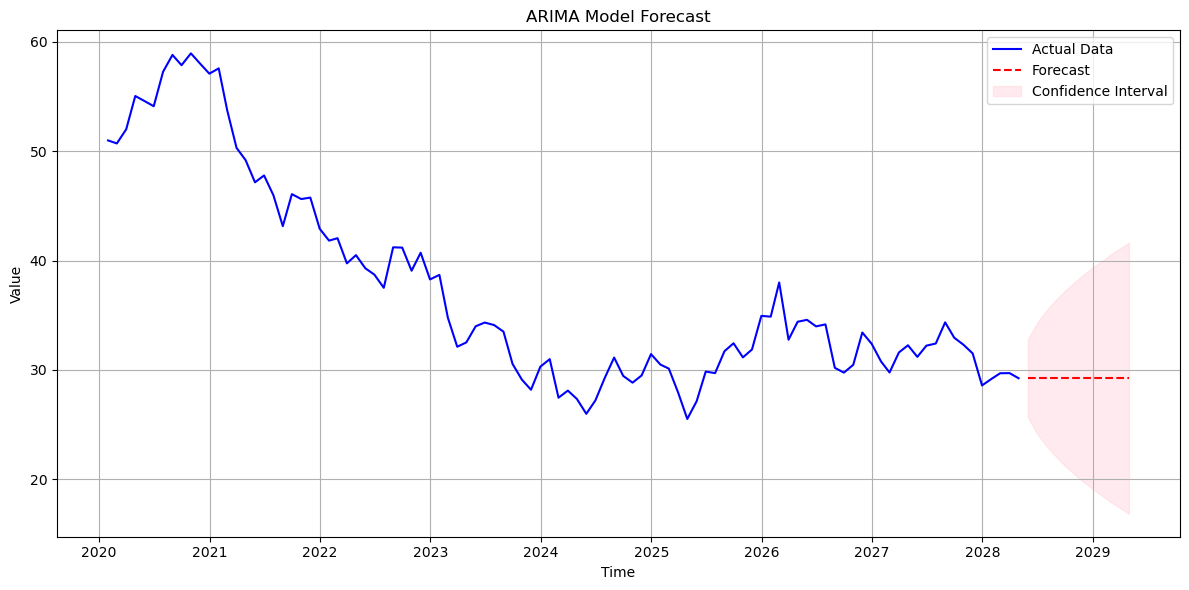

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Simulate two interdependent time series
np.random.seed(42)
time = pd.date_range(start="2020-01", periods=100, freq="ME")
industrial_production = 50 + np.cumsum(np.random.normal(0, 2, 100))

# Create a DataFrame
data = pd.DataFrame({
    "Industrial_Production": industrial_production,
}, index=time)

# Plot the time series
data.plot(figsize=(12, 6), title="Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

# Step 1: Check stationarity
result = adfuller(data)
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] > 0.05:
    print("The series is non-stationary. Differencing required.")

# Differencing the data
data_diff = data.diff().dropna()

# Plot differenced data
data_diff.plot(figsize=(12, 6), title="Differenced Time Series")
plt.xlabel("Time")
plt.ylabel("Differenced Value")
plt.grid()
plt.show()

# Step 2: ACF and PACF plots for ARIMA order selection
plot_acf(data_diff, lags=20, title="ACF of Differenced Series")
plt.show()

plot_pacf(data_diff, lags=20, title="PACF of Differenced Series")
plt.show()

# Step 3: Use auto_arima to identify the best ARIMA model
model = auto_arima(data, seasonal=False, trace=True, stepwise=True, suppress_warnings=True, max_p=5, max_q=5, max_d=2)
print(model.summary())

# Step 4: Fit the selected ARIMA model
fitted_model = model.fit(data)

# Step 5: Forecasting
forecast, conf_int = model.predict(n_periods=12, return_conf_int=True)
forecast_index = pd.date_range(data.index[-1] + pd.DateOffset(1), periods=12, freq="M")
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot actual, forecast, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(data, label="Actual Data", color="blue")
plt.plot(forecast_series, label="Forecast", color="red", linestyle="--")
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color="pink", alpha=0.3, label="Confidence Interval")
plt.title("ARIMA Model Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
